In [1]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

In [2]:
DISCOVER_HOST = '10.0.0.4'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [3]:
[session['session_id'] for session in client.list_sessions()['result']]

['experiment_fedavg_LF_08_00',
 'experiment_fedavg_LF_07_01',
 'experiment_fedavg_LF_06_02',
 'experiment_fedavg_LF_05_03']

In [4]:
session_id = input("Provide a session_id: ")

Provide a session_id:  experiment_fedavg_LF_05_03


In [5]:
models = client.list_models(session_id)
# models

In [6]:
num_rounds = models['count']
# num_rounds

In [7]:
# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [8]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'training_loss': json.loads(worker_result['data'])['training_loss'],
            'training_accuracy': json.loads(worker_result['data'])['training_accuracy'],
            'test_loss': json.loads(worker_result['data'])['test_loss'],
            'test_accuracy': json.loads(worker_result['data'])['test_accuracy']
        }
        
        validations.append(validation)
        

In [9]:
# validations

In [10]:
# set([validation['client_name'] for validation in validations])

In [11]:
graph_data = {
    'training_loss': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'training_accuracy': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_loss': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_accuracy': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_training_loss': [],
    'overall_training_accuracy': [],
    'overall_test_loss': [],
    'overall_test_accuracy': []
}

In [12]:
for validation in validations:
    graph_data['training_loss'][validation['client_name']]['data'].append(validation['training_loss'])
    graph_data['training_accuracy'][validation['client_name']]['data'].append(validation['training_accuracy'])
    graph_data['test_loss'][validation['client_name']]['data'].append(validation['test_loss'])
    graph_data['test_accuracy'][validation['client_name']]['data'].append(validation['test_accuracy'])

In [13]:
graph_data['overall_training_loss'] = [np.mean([graph_data['training_loss'][key]['data'][i] for key in graph_data['training_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_training_accuracy'] = [np.mean([graph_data['training_accuracy'][key]['data'][i] for key in graph_data['training_accuracy'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_loss'] = [np.mean([graph_data['test_loss'][key]['data'][i] for key in graph_data['test_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_accuracy'] = [np.mean([graph_data['test_accuracy'][key]['data'][i] for key in graph_data['test_accuracy'].keys()]) for i in range(num_rounds)]

In [14]:
# graph_data

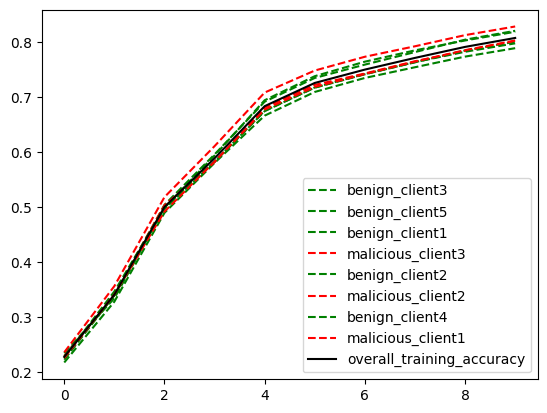

In [15]:
x = range(num_rounds)
metric_type = "training_accuracy"

for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')
    
plt.legend([label for label in graph_data[metric_type].keys()] + [f'overall_{metric_type}'])
plt.show()

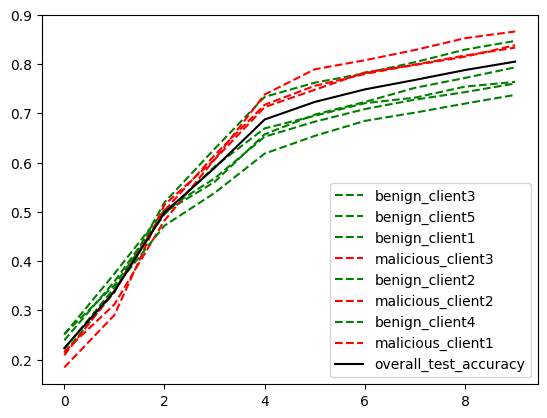

In [16]:
x = range(num_rounds)
metric_type = "test_accuracy"

for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')
    
plt.legend([label for label in graph_data[metric_type].keys()] + [f'overall_{metric_type}'])
plt.show()

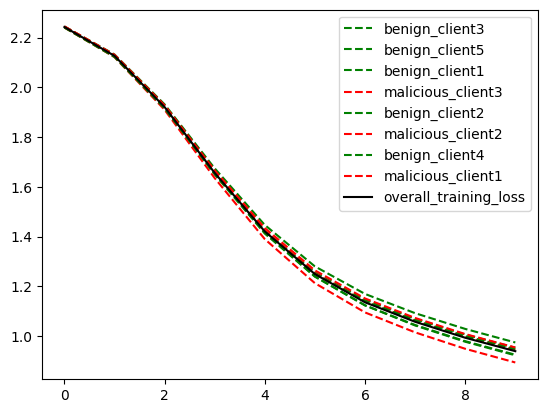

In [17]:
x = range(num_rounds)
metric_type = "training_loss"

for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')
    
plt.legend([label for label in graph_data[metric_type].keys()] + [f'overall_{metric_type}'])
plt.show()

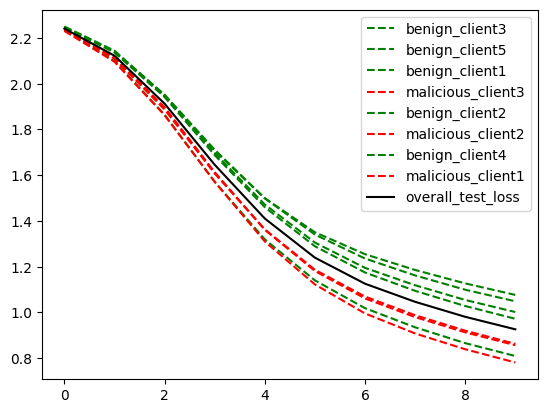

In [18]:
x = range(num_rounds)
metric_type = "test_loss"

for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')
    
plt.legend([label for label in graph_data[metric_type].keys()] + [f'overall_{metric_type}'])
plt.show()